# Debunk synthetic ensembles

My notes:

I’m having trouble being excited about writing right now, so I’m working on my methods figures. I think that I will try to do the “debunking synthetic ensemble” figure now. I will generally follow the methods of Sledd 2021 to create a synthetic ensemble and then compare it with a “true” ensemble from the CESM1-LE.

“To calculate these synthetic time series, we again assume the data can be represented by the sum of a linear trend and noise.” - The noise and the linearity assumption are both going to be issues. Linearity less so for OLR, but perhaps more for other variables.

“We take the variance calculated from Eq. (1) and generate a series of random noise with zero mean from it. On top of this noise, we can add a linear trend, illustrated in Fig. 2a. Synthetic time series are continued to 150 years, which is long enough for trends from all CMIP6 models to emerge under both SSP245 and SSP585. Synthetic ensembles are composed of 300 individual time series. This process can be applied to models as well as observations to create ensembles of time series.”

Eq. (1): Variance(Nt) = sigmaN2 (1 - lag12)

Also Sledd considers a trend to have emerged when it REMAINS above the SNR threshold. I like this and having a published precedent is nice too.

I’ll calculate this variance and then create my random noise using numpy’s random package:

noise = np.random.normal(0,1,100)

_0 is the mean of the normal distribution you are choosing from_  
_1 is the standard deviation of the normal distribution_  
_100 is the number of elements you get in array noise_  

Then I can add this noise to a linear trend. ← Chosen as any of the ensemble members.


__I want to demonstrate that using a single simulation and creating a synthetic ensemble for it doesn't appropriately capture the same variability of a large ensemble.__

1. The trend that is calculated could be significantly higher or lower than the forced response, meaning that the synthetic ensemble inherits this bias. (I could show this).

2. If the trend of the single simulation is nearly the forced response, it still likely will not capture the range of trends exhibited by a truth ensemble. (I could also show this)

__Steps:__

1. Open the large ensemble OLR timeseries.

2. Pick a member with a slope that is somewhat different from the forced response, create a synthetic ensemble based on it and compare them. (quantify how this biases the average prediction of climate signal emergence, perhaps I could quantify the likelihood of a XX% bias?)

3. Pick the forced response, create a synthetic ensemble based on it and compare it to the LENS. Quantify how the 95% confidence intervals on forced slopes and climate signal emergence differ.

__I have a good instructive figure to show that synthetic ensembles will distort the "true" internal climate variability, but I want to numerically demonstrate how often this occurs. One option is to generate probability distributions of forced trends from synthetic ensembles based on all the available ensemble members and determine if they are statistically different from the "true" probability distribution of the large ensemble.__

Nicola recommended using a K-S test to do this. The relevant wikipedia page is quite useful: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test



The Kolmogorov–Smirnov test may also be used to test whether two underlying one-dimensional probability distributions differ. In this case, the Kolmogorov–Smirnov statistic is

$$ {\displaystyle D_{n,m}=\sup _{x}|F_{1,n}(x)-F_{2,m}(x)|,} $$

where ${F_{1,n}}$ and ${F_{2,m}}$ are the empirical distribution functions of the first and the second sample respectively, and ${\displaystyle \sup }$ is the supremum function.

For large samples, the null hypothesis is rejected at level ${\displaystyle \alpha }$ if

$$ {\displaystyle D_{n,m}>c(\alpha ){\sqrt {\frac {n+m}{n\cdot m}}}.} $$

Where ${\displaystyle n}$ and ${\displaystyle m}$ are the sizes of first and second sample respectively. The value of ${\displaystyle c({\alpha })}$ is given in the table below for the most common levels of  $\alpha$  
$\alpha$ 	0.20 	0.15 	0.10 	0.05 	0.025 	0.01 	0.005 	0.001  
$c({\alpha })$ 	1.073 	1.138 	1.224 	1.358 	1.48 	1.628 	1.731 	1.949

and in general[19] by

$$ {\displaystyle c\left(\alpha \right)={\sqrt {-\ln \left({\tfrac {\alpha }{2}}\right)\cdot {\tfrac {1}{2}}}},}$$

so that the condition reads

$${\displaystyle D_{n,m}>{\sqrt {-\ln \left({\tfrac {\alpha }{2}}\right)\cdot {\tfrac {1+{\tfrac {m}{n}}}{2m}}}}.}$$

Here, again, the larger the sample sizes, the more sensitive the minimal bound: For a given ratio of sample sizes (e.g. m = n), the minimal bound scales in the size of either of the samples according to its inverse square root. 

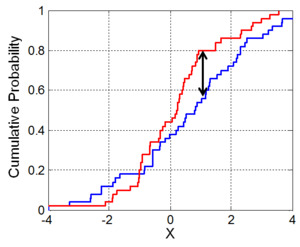

Illustration of the two-sample Kolmogorov–Smirnov statistic. Red and blue lines each correspond to an empirical distribution function, and the black arrow is the two-sample KS statistic.

Fortunately, this code already exists in python (I don't have to hardcode it in, would I guess would have been fun)! See example below my imports.

## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__KS Test example__

In [2]:
# not sure why using numpy and not np works here...
from numpy.random import seed
from numpy.random import randn
from numpy.random import lognormal

#set seed (e.g. make this example reproducible)
seed(0)

#generate two datasets
data1 = randn(100)
data2 = lognormal(3, 1, 100)

In [3]:
from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test
ks_2samp(data1, data2)

KstestResult(statistic=0.99, pvalue=4.417521386399011e-57)

In [4]:
# norm_cdf1 = stats.norm.cdf(data1)
# norm_cdf2 = stats.norm.cdf(data2)

# plt.scatter(data1,norm_cdf1)
# plt.scatter(data2,norm_cdf2)
# plt.xlim(-4,10)

# sns.lineplot(data1,norm_cdf1)

### Load pre-processed timeseries

Model output.

In [4]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

In [8]:
# open lens variability characteristics calculated from the PI-Control run (want OLR annual values)
ens_variability_filepath = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

lens_variability_data = xr.open_dataset(ens_variability_filepath)

In [7]:
olr_annual_variability = lens_variability_data.sel(variable='FLUT',month=13)

olr_annual_stddev = olr_annual_variability['stddev']
olr_annual_tauvar = olr_annual_variability['tauvar']

In [100]:
# Quickly estimate the lag-1 autocorrelation
lag1s = np.linspace(0.001,0.999,1000)
taus = (1+lag1s) / (1-lag1s)

lag1_ind = np.argmin(np.abs(taus - olr_annual_tauvar.values))
olr_annual_lag1 = lag1s[lag1_ind]

In [9]:
def pi_tseries_to_ens(pic_var_dict,tlength,nmembers,verbose=True):
    '''
    This function takes a long control run and returns N (nmembers) non-overlapping members of length tlength (years).
    If the long control run does not have enough time for this, the function returns as many members as fit in.
    '''
    
    month_increment = tlength*12 # length of the timeseries

    pic_final_dict = {}
    for _var in pic_var_dict: # iterate over keys, which are the variables
        if verbose:
            print(_var)

        pic_tseries_dict = {}

        for mem_n in range(nmembers):
            # Define index start and endpoints
            start_index = mem_n*month_increment
            end_index = start_index + month_increment

            if end_index > len(pic_var_dict[_var].time):
                print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
                break
            sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

            # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

            # create a fake timeseries so that we can combine these fake ensemble members
            # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
            new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
            new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
            sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

            sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

            pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

        pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')

        pic_final_dict[_var] = pic_all_tseries
    
    return pic_final_dict

In [10]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right (this doesn't work, just adds a new non-index coordinate)
    # ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

In [11]:
def simple_detrend(tseries,dim):
    '''
    Pass a timeseries and the dimension to detrend along.
    '''
    
    polyfit = tseries.polyfit(dim=dim,deg=1) # take a linear fit
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    
    linearized_tseries = slopes.sel(degree=1)*tseries[dim] + slopes.sel(degree=0) # construct the linear fit
    detrended_tseries  = tseries - linearized_tseries # remove the linear fit to detrend the timeseries
    
    return detrended_tseries

In [12]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate

In [13]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data,testing=False):
    ''' Standardize the data. '''
    
    # if data.std()==0: # edge case that the standard deviation is zero
    if np.isclose(data.std(),0,atol=1e-5): # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    if testing:
        print(data)
        print(data_std)
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [155]:
def calc_confidence_interval(data,CI):
    '''
    Calculate a confidence interval on data
    $$ \mu = \bar{x} \pm z_{\alpha/2} \frac{\sigma}{\sqrt{N}} $$
    '''
    
    alpha = 1 - CI
    N = data.shape[0]
    
    t_crit = np.abs(stats.t.ppf(alpha/2,df=N)) # calculate a critical t-statistic
    
    mean = np.mean(data)
    std  = np.std(data)
    
    # Calculate the bounds of the confidence interval
    low  = mean - t_crit*std # / np.sqrt(N-1) # <-- decision about this
    high = mean + t_crit*std # / np.sqrt(N-1)
    
    bounds_da = xr.DataArray(
        data=np.array([low,high]),
        dims=["bound"],
        coords=dict(
            bound=[0,1]
        ),
    # name = 'wat'
    )
    
    return bounds_da

In [14]:
var_name = 'FLUT'
ens17_response_ann = cesm1_ensresponse_ds[var_name].sel(ens=17).groupby('time.year').mean('time')


In [17]:
ens17_detrended = simple_detrend(ens17_response_ann,dim='year')

In [18]:
ens17_variance = np.std(ens17_detrended)**2

In [19]:
ens17_lag1 = calc_lag1_autocorr(ens17_detrended)

$$ \sigma_e^2 = Variance(N_t) = \sigma_N^2 (1 - \phi^2) $$

Unfortunately, this still doesn't make sense to me. Shouldn't the standard deviation/variance calculated from the detrended timeseries be $\sigma_e$, which combines the AR(1) process and the white noise $\sigma_N$? But by matching Eq. 2 in Sledd with any other time-to-emergence approach, $\sigma_N$ is clearly the variance of the detrended timeseries. So maybe the above equation is just saying that the combined effects can be summarized as just a single white noise process with a scaled variance. Still doesn't feel right to me, but that's OK because at least the math is clear!

In [20]:
ens17_sigmae = ens17_variance * (1 - ens17_lag1**2)

Produce the noise now!

In [24]:
# Create a "lucky" synthetic ensemble centered around the forced response.
forced_response_ann = cesm1_ensresponse_ds[var_name].groupby('time.year').mean('time').mean(dim='ens')

# Create the linear slope to create our synthetic timeseries around.
polyfit = forced_response_ann.polyfit(dim='year',deg=1)
slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
linearized_tseries = slopes.sel(degree=1)*forced_response_ann['year'] + slopes.sel(degree=0) # construct the linear fit

new_synths = []
for i in range(1000): # 40,300
    noise = np.random.normal(0,np.sqrt(ens17_sigmae),80) # noise for each of the 80 years
    
    _synthetic_member = linearized_tseries + noise # adding the noise to a linear fit of the forced response
    
    _synthetic_member_da = xr.DataArray(_synthetic_member,[('year', forced_response_ann['year'])])
    _synthetic_member_da['ens'] = i+1
    
    new_synths.append(_synthetic_member_da)
        
synthetic_ens = xr.concat(new_synths,dim='ens')

Text(0.5, 1.0, 'Synthetic Ensemble')

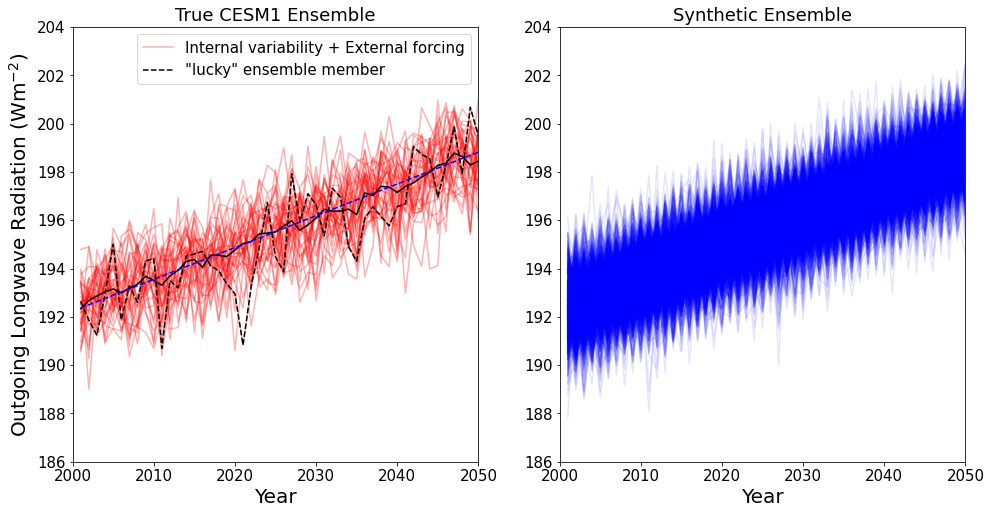

In [25]:
ens_fig,ens_ax = plt.subplots(1,2,figsize=(16,8))

var_name = 'FLUT'

####### Panel 1
# create an unforced "ensemble" from the CESM1 control simulation
members_of_dur = pi_tseries_to_ens(cesm1_pic_ds[[var_name]],tlength=50,nmembers=36,verbose=False) # aim for 40 members (same as the CESM1-LENS)

# Plot forced timeseries from the CESM1-LE
for forced_ens,unforced_ens in zip(cesm1_ensresponse_ds[var_name],members_of_dur[var_name]):
    
    unforced_ens_annavg = unforced_ens.groupby('time.year').mean('time')
    forced_ens_annavg = forced_ens.groupby('time.year').mean('time')
    
    # lines1 = ens_ax[0].plot(forced_ens_annavg.year,unforced_ens_annavg, color='blue',alpha=0.3,
    #                         label='Internal variability') 
    lines0 = ens_ax[0].plot(forced_ens_annavg.year,forced_ens_annavg, color='red',alpha=0.3,
                            label='Internal variability + External forcing')

    
forced_response_ann = cesm1_ensresponse_ds[var_name].groupby('time.year').mean('time').mean(dim='ens')
ens_ax[0].plot(forced_response_ann.year,forced_response_ann,color='black')

ens17_response_ann = cesm1_ensresponse_ds[var_name].sel(ens=17).groupby('time.year').mean('time')
lines2 = ens_ax[0].plot(ens17_response_ann.year,ens17_response_ann,color='black',linestyle='dashed',label='"lucky" ensemble member')
ens_ax[0].plot(linearized_tseries.year,linearized_tseries,color='blue',linestyle='dashed')

    # ^have to use the other time here so they line up

ens_ax[0].set_xlim(2000,2050)
ens_ax[0].set_ylim(186,204)

ens_ax[0].set_xlabel('Year',fontsize=20)
ens_ax[0].set_ylabel('Outgoing Longwave Radiation (Wm$^{-2}$)',fontsize=20)
ens_ax[0].tick_params(axis='both', labelsize=15)
# ens_ax[0].set_edgecolor('black')
ens_ax[0].legend(handles=[lines0[0],lines2[0]],facecolor='white',fontsize=15)
ens_ax[0].set_title('True CESM1 Ensemble',fontsize=18)

for forced_synth in synthetic_ens:
    
    lines0 = ens_ax[1].plot(forced_synth.year,forced_synth, color='blue',alpha=0.1,
                            label='Synthetic Ensemble')
    

ens_ax[1].set_xlim(2000,2050)
ens_ax[1].set_ylim(186,204)

ens_ax[1].set_xlabel('Year',fontsize=20)
# ens_ax[1].set_ylabel('Outgoing Longwave Radiation (Wm$^{-2}$)',fontsize=20)
ens_ax[1].tick_params(axis='both', labelsize=15)
ens_ax[1].set_title('Synthetic Ensemble',fontsize=18)

So the synthetic ensemble actually seems to be doing pretty well when we let it work with a single member with a trend as the forced response. This is actually great. What about the bias effect if we give it less-ideal ensemble members?

In [26]:
_synth_ens_polyfit = synthetic_ens.polyfit(dim='year',deg=1)
_synth_slopes      = _synth_ens_polyfit.sel(degree=1)['polyfit_coefficients']

In [27]:
true_ens_ann_tseries = cesm1_ensresponse_ds[var_name].groupby('time.year').mean('time')

_true_ens_polyfit = true_ens_ann_tseries.polyfit(dim='year',deg=1)
_true_slopes      = _true_ens_polyfit.sel(degree=1)['polyfit_coefficients']

In [28]:
#perform Kolmogorov-Smirnov test
ks_2samp(_synth_slopes, _true_slopes)

KstestResult(statistic=0.125, pvalue=0.5467817371025024)

For the ideal case, we cannot distinguish the distributions at 95% confidence (p > 0.05). What about for other cases?

__Create unaided synthetic ensembles from 80 years of model data.__

In [149]:
new_ens = []
for _ens in cesm1_ensresponse_ds['FLUT']: # iterate over the "real" ensemble members
    
    ens_response_ann = _ens.groupby('time.year').mean('time')
    ens_detrended = simple_detrend(ens_response_ann,dim='year')
    
    # Calculate the characteristic noise (per Sledd 2021)
    ens_variance = np.std(ens_detrended)**2
    ens_lag1 = calc_lag1_autocorr(ens_detrended)
    ens_sigmae = ens_variance * (1 - ens_lag1**2)
    
    # Calculate the linear slope to create our synthetic timeseries around.
    polyfit = ens_response_ann.polyfit(dim='year',deg=1)
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    linearized_tseries = slopes.sel(degree=1)*ens_response_ann['year'] + slopes.sel(degree=0) # construct the linear fit

    new_synths = []
    for i in range(300): # Now iterate to make a synthetic ensemble of 1000/300 members
        noise = np.random.normal(0,np.sqrt(ens_sigmae),80) # noise for each of the 80 years

        _synthetic_member = linearized_tseries + noise # adding the noise to a linear fit of the forced response

        _synthetic_member_da = xr.DataArray(_synthetic_member,[('year', forced_response_ann['year'])])
        _synthetic_member_da['ens'] = ens_response_ann['ens'] # label the true ensemble
        _synthetic_member_da['synth'] = i+1 # label the synthetic ensemble number

        new_synths.append(_synthetic_member_da)
    
    synthetic_ens = xr.concat(new_synths,dim='synth')
    
    # # calculate the slopes for the synthetic ensemble
    # _synth_ens_polyfit = synthetic_ens.polyfit(dim='year',deg=1)
    # _synth_slopes      = _synth_ens_polyfit.sel(degree=1)['polyfit_coefficients']
    
    new_ens.append(synthetic_ens)
    
all_synth_ens_da = xr.concat(new_ens,dim='ens')

In [131]:
flat_tseries = cesm1_ensresponse_ds['FLUT'].groupby('time.year').mean('time').groupby('ens').map(simple_detrend,dim='year')

In [143]:
avg_synth_stddev = flat_tseries.std(dim='year').mean()
print(avg_synth_stddev)

<xarray.DataArray ()>
array(1.22497719)


In [124]:
olr_annual_stddev

<xarray.DataArray 'stddev' ()>
array(1.147661)
Coordinates:
    variable  <U4 'FLUT'
    month     int64 13

The 80 year detrended timeseries surprisingly have greater average variance than the PI-Control simulation, but not by a ton...

In [145]:
avg_synth_lag1 = flat_tseries.groupby('ens').map(calc_lag1_autocorr).mean()
print(avg_synth_lag1)

<xarray.DataArray ()>
array(0.15167136)


In [129]:
olr_annual_lag1

0.38761261261261265

They also have significantly less autocorrelation, which isn't surprising.

The net effect on the synthetic noise when true vs. assumed variability is concerned is that the synthetic ensembles have greater noise by ~30%. So in this case "aiding" the synthetic ensembles is a bad idea when it comes to generating them because we reduce their variability since the autocorrelation is lower. I imagine the synthetic ensemble methods might explain why if you are detrending you should use the noise from the real detrended data.

In [142]:
olr_annual_stddev**2 * (1 - olr_annual_lag1**2)

<xarray.DataArray 'stddev' ()>
array(1.11923581)
Coordinates:
    variable  <U4 'FLUT'
    month     int64 13

In [146]:
avg_synth_stddev**2 * (1 - avg_synth_lag1**2)

<xarray.DataArray ()>
array(1.46604973)

__Create aided synthetic ensembles from 80 years of model data and the PI-Control internal variability.__

These aided synthetic ensembles will get the forced slope wrong and the variability wrong because the variability should come from the detrended data. 

I thought they would do better, but they do worse --> They should do much better when compared with the "true" emergence from the large ensemble.

In [101]:
new_ens = []
for _ens in cesm1_ensresponse_ds['FLUT']: # iterate over the "real" ensemble members
    
    ens_response_ann = _ens.groupby('time.year').mean('time')
    ens_detrended = simple_detrend(ens_response_ann,dim='year')
    
    # Calculate the characteristic noise (per Sledd 2021)
    ens_variance = olr_annual_stddev**2 # from the large ensemble
    ens_lag1 = olr_annual_lag1 # from the large ensemble
    ens_sigmae = ens_variance * (1 - ens_lag1**2)
    
    # Calculate the linear slope to create our synthetic timeseries around.
    polyfit = ens_response_ann.polyfit(dim='year',deg=1)
    slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
    linearized_tseries = slopes.sel(degree=1)*ens_response_ann['year'] + slopes.sel(degree=0) # construct the linear fit

    new_synths = []
    for i in range(300): # Now iterate to make a synthetic ensemble of 1000/300 members
        noise = np.random.normal(0,np.sqrt(ens_sigmae),80) # noise for each of the 80 years

        _synthetic_member = linearized_tseries + noise # adding the noise to a linear fit of the forced response

        _synthetic_member_da = xr.DataArray(_synthetic_member,[('year', forced_response_ann['year'])])
        _synthetic_member_da['ens'] = ens_response_ann['ens'] # label the true ensemble
        _synthetic_member_da['synth'] = i+1 # label the synthetic ensemble number

        new_synths.append(_synthetic_member_da)
    
    synthetic_ens = xr.concat(new_synths,dim='synth')
    
    new_ens.append(synthetic_ens)
    
all_synth_ens_aided_da = xr.concat(new_ens,dim='ens')

Test if the synthetic ensembles produces distributions of slopes similar to the "true" large ensemble.

In [153]:
# now iterate over the synthetic slopes by ensemble source member and determine if they are distinguishable from the true value

notthesame = 0
for synthetic_ens in all_synth_ens_da:
    
    # calculate the slopes for the synthetic ensemble
    _synth_ens_polyfit = synthetic_ens.polyfit(dim='year',deg=1)
    _synth_slopes      = _synth_ens_polyfit.sel(degree=1)['polyfit_coefficients']
    
    out = ks_2samp(_synth_slopes, _true_slopes)
    
    # calculate a percent error from the "true" forced response
    true_meanslope  = _true_slopes.mean()
    synth_meanslope = _synth_slopes.mean()
    
    true_95conf = np.percentile(_true_slopes,97.5) - np.percentile(_true_slopes,2.5)
    synth_95conf = np.percentile(_synth_slopes,97.5) - np.percentile(_synth_slopes,2.5)
    
    percent_error_meanslope = (synth_meanslope - true_meanslope) / true_meanslope
    percent_error_slope95conf = (synth_95conf - true_95conf) / true_95conf
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean slope: %.3f (%.0f), Slope spread: %.3f (%.0f) .BAD.' % (synth_meanslope,100*percent_error_meanslope,synth_95conf,100*percent_error_slope95conf))
        # print('Slope spread: %.3f (%.0f)' % (synth_95conf,100*percent_error_slope95conf))
    else:
        print('Mean slope: %.3f (%.0f), Slope spread: %.3f (%.0f) .GOOD.' % (synth_meanslope,100*percent_error_meanslope,synth_95conf,100*percent_error_slope95conf))
        # print('Mean slope: %.3f (GOOD %.0f)' % (synth_meanslope,100*percent_error_meanslope))
        # print('Slope spread: %.3f (%.0f)' % (synth_95conf,100*percent_error_slope95conf))
        
print(notthesame)

Mean slope: 0.145 (10), Slope spread: 0.024 (-5) .BAD.
Mean slope: 0.120 (-9), Slope spread: 0.021 (-20) .BAD.
Mean slope: 0.122 (-8), Slope spread: 0.023 (-9) .BAD.
Mean slope: 0.134 (1), Slope spread: 0.022 (-14) .BAD.
Mean slope: 0.131 (-1), Slope spread: 0.020 (-22) .GOOD.
Mean slope: 0.135 (2), Slope spread: 0.024 (-5) .BAD.
Mean slope: 0.114 (-13), Slope spread: 0.026 (2) .BAD.
Mean slope: 0.126 (-4), Slope spread: 0.026 (1) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.022 (-13) .BAD.
Mean slope: 0.131 (-1), Slope spread: 0.022 (-13) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.021 (-18) .BAD.
Mean slope: 0.121 (-8), Slope spread: 0.024 (-6) .BAD.
Mean slope: 0.136 (4), Slope spread: 0.022 (-15) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.024 (-8) .GOOD.
Mean slope: 0.129 (-2), Slope spread: 0.024 (-5) .BAD.
Mean slope: 0.126 (-4), Slope spread: 0.021 (-19) .BAD.
Mean slope: 0.152 (15), Slope spread: 0.021 (-18) .BAD.
Mean slope: 0.136 (3), Slope spread: 0.021 (-17) .BAD.
Mean s

The mean slope error is centered around zero (sampling of ensemble members), but the spread of slopes is consistently underestimated.

At 50 years, the percent error needs to be <3% to generate a statistically similar dataset and around two thirds of synthetic ensembles are statistically different from the true distribution of slopes.

At 80 years, the percent error needs to be less than 1% to generate a statistically similar distribution of slopes.

What about for predicted emergence times? I'd expect more synthetically derived ensembles to look like the true distribution since the dependence on slope is $\propto m^{-2/3}$, but if we included the effect of underestimating variability I expect the results would look quite different.  

I can either investigate if the slopes only cause a problem or also include the effect of the variability being different. May I'll iterate slowly.

In [154]:
# now iterate over the synthetic slopes by ensemble source member and determine if they are distinguishable from the true value

notthesame = 0
for synthetic_ens in all_synth_ens_aided_da:
    
    # calculate the slopes for the synthetic ensemble
    _synth_ens_polyfit = synthetic_ens.polyfit(dim='year',deg=1)
    _synth_slopes      = _synth_ens_polyfit.sel(degree=1)['polyfit_coefficients']
    
    out = ks_2samp(_synth_slopes, _true_slopes)
  
    # calculate a percent error from the "true" forced response
    true_meanslope  = _true_slopes.mean()
    synth_meanslope = _synth_slopes.mean()
    
    true_95conf = np.percentile(_true_slopes,97.5) - np.percentile(_true_slopes,2.5)
    synth_95conf = np.percentile(_synth_slopes,97.5) - np.percentile(_synth_slopes,2.5)
    
    percent_error_meanslope = (synth_meanslope - true_meanslope) / true_meanslope
    percent_error_slope95conf = (synth_95conf - true_95conf) / true_95conf
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean slope: %.3f (%.0f), Slope spread: %.3f (%.0f) .BAD.' % (synth_meanslope,100*percent_error_meanslope,synth_95conf,100*percent_error_slope95conf))
        # print('Slope spread: %.3f (%.0f)' % (synth_95conf,100*percent_error_slope95conf))
    else:
        print('Mean slope: %.3f (%.0f), Slope spread: %.3f (%.0f) .GOOD.' % (synth_meanslope,100*percent_error_meanslope,synth_95conf,100*percent_error_slope95conf))
        # print('Mean slope: %.3f (GOOD %.0f)' % (synth_meanslope,100*percent_error_meanslope))
        # print('Slope spread: %.3f (%.0f)' % (synth_95conf,100*percent_error_slope95conf))
        
print(notthesame)
#     # calculate a percent error from the "true" forced response
#     true_meanslope  = _true_slopes.mean()
#     synth_meanslope = _synth_slopes.mean()
#     percent_error = np.abs(true_meanslope - synth_meanslope) / true_meanslope
    
#     if out[1] < 0.05: # if different from the true distribution at 95% confidence
#         notthesame += 1
#         print('Mean slope: %.3f (BAD. %.0f)' % (synth_meanslope,100*percent_error))
#     else:
#         print('Mean slope: %.3f (GOOD %.0f)' % (synth_meanslope,100*percent_error))
# print(notthesame)

Mean slope: 0.145 (10), Slope spread: 0.018 (-29) .BAD.
Mean slope: 0.120 (-8), Slope spread: 0.020 (-20) .BAD.
Mean slope: 0.122 (-8), Slope spread: 0.020 (-21) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.020 (-23) .BAD.
Mean slope: 0.131 (-0), Slope spread: 0.018 (-31) .GOOD.
Mean slope: 0.135 (3), Slope spread: 0.019 (-25) .BAD.
Mean slope: 0.114 (-14), Slope spread: 0.019 (-27) .BAD.
Mean slope: 0.126 (-4), Slope spread: 0.020 (-23) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.019 (-27) .BAD.
Mean slope: 0.131 (-0), Slope spread: 0.019 (-25) .GOOD.
Mean slope: 0.133 (1), Slope spread: 0.020 (-22) .BAD.
Mean slope: 0.122 (-7), Slope spread: 0.021 (-17) .BAD.
Mean slope: 0.136 (3), Slope spread: 0.020 (-24) .BAD.
Mean slope: 0.134 (2), Slope spread: 0.020 (-20) .BAD.
Mean slope: 0.128 (-3), Slope spread: 0.019 (-27) .BAD.
Mean slope: 0.126 (-4), Slope spread: 0.019 (-26) .BAD.
Mean slope: 0.153 (16), Slope spread: 0.020 (-21) .BAD.
Mean slope: 0.136 (3), Slope spread: 0.019 (-27) .B

Similar issue here with the poorly "aided" synthetic ensemble, except that the spread bias is even worse!

In [44]:
def predict_emergence_singlereal(tseries,sigma_var=None,tau_var=None,s=2,):
    '''
    Predict the emergence of a climate signal given a single realization (timeseries).
    1. Calculate a background of internal variability for the entire timeseries (sigma_var, tau_var)
    2. Calculate a linear forced response (trend) for different durations
    3. Use the Weatherhead approach to determine if a trend exceeds 95% of internal variability
    4. The date is when the signal exits internal variability for the last time.
    '''
    
    all_dims  = list(tseries.dims)
    time_dim  = all_dims[0] # Get the time dimension (tseries should be 1-d)
    durations = np.arange(2,tseries.shape[0])
    
    # 2. Calculate a linear forced response (trend) for different durations
    lens_slopes_dict = {}
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset = tseries.isel({time_dim:slice(None,_dur)}) # subset the data in time

        _lens_polyfit = tseries_dur_subset.polyfit(dim=time_dim,deg=1) # take a linear fit
        _lens_slopes = _lens_polyfit['polyfit_coefficients'].sel(degree=1).values # pull out the slope from the linear fit

        lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary

    # shift the data to an xarray object so future operations do not require iteration
    _temp_slopes_da = xr.DataArray(
        data=list(lens_slopes_dict.values()),
        dims=["duration"],
        coords=dict(
            duration=(durations),
        ),
        # name = _var
    )
    
    # 0. Calculate sigma_var or tau_var if they are not passed
    if (sigma_var is None) or (tau_var is None):
        
        ens_detrended = simple_detrend(tseries,dim='year')
    
        # Calculate the characteristic variability properties for the whole timeseries
        ens_sigma_var = np.std(ens_detrended)
        ens_lag1 = calc_lag1_autocorr(ens_detrended)
        ens_tau_var = (1 + ens_lag1) / (1 - ens_lag1)
        
        if sigma_var is None:
            sigma_var = ens_sigma_var
        if tau_var is None:
            tau_var = ens_tau_var
    
    # 1. Calculate a background of internal variability for each duration of the entire timeseries (sigma_var, tau_var)
    # For now I am going to pass these arguments in from the large ensemble (could add flexibility later)
    TTE = (12*s**2 * sigma_var**2 * tau_var / _temp_slopes_da**2)**(1/3) # time to emergence following the standard Weatherhead/Leroy/Phojan approach
    
    detect_TTE = TTE < TTE.duration # has emergence already occurred?
    # We first take the duration and broadcast it across variables and months.
    duration_broad = detect_TTE.duration.broadcast_like(detect_TTE)
    # Then we select the gridcells where detection did not occur. Emergence is one year after the last year where detection did not occur (maximum duration of non-detections.
    emergence_ds = 1 + duration_broad.where(~detect_TTE).max(dim='duration')
    # Fill areas where emergence did not occur with nans
    emergence_ds = xr.where(emergence_ds > 50,np.nan,emergence_ds)
    
    return emergence_ds

Calculate the emergence of the CESM1-LE using internal variability estimated from the 1800-yr PIC control simulation.

In [31]:
cesm1_olr_annual = cesm1_ensresponse_ds['FLUT'].groupby('time.year').mean('time')

In [45]:
# Estimate emergence with the "true" internal variability
true_emerge_ens = cesm1_olr_annual.groupby('ens').map(predict_emergence_singlereal,sigma_var=olr_annual_stddev,tau_var=olr_annual_tauvar)

# Estimate emergence with internal variability estimated from each 80 year timeseries
true_emerge_ensS = cesm1_olr_annual.groupby('ens').map(predict_emergence_singlereal)

(array([ 3., 13., 11.,  8.,  1.,  2.]),
 array([10, 15, 20, 25, 30, 35, 40]),
 <BarContainer object of 6 artists>)

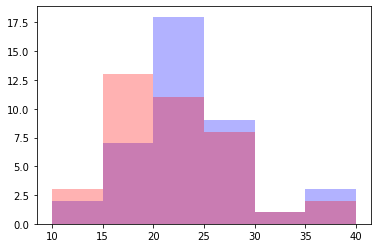

In [55]:
histo_bins = np.arange(10,41,5)
histo_centers = np.convolve(histo_bins,np.ones(2)/2,mode='valid') # <-- cool convolution approach (histo_bins + 2.5)[:-1]

plt.hist(np.array(true_emerge_ens),histo_bins,alpha=0.3,color='blue',label='"true" internal variability')
plt.hist(np.array(true_emerge_ensS),histo_bins,alpha=0.3,color='red',label='internal variability from 80 years')

The ensemble members used here are the same, the only thing that is different is the estimate of the internal climate variability! Blue uses 1800-years of pre-industrial control and Red uses 80 years detrended.

The "true" emergence times appear to be normally distributed.

In [ ]:
calc_confidence_interval

In [56]:
# subset to test functionality before running code for 10 min
all_synth_ens_da_subset = all_synth_ens_da.sel(ens=slice(None,5),synth=slice(None,10))

In [57]:
%%time
true_emerge_allsynth_unaidedS = all_synth_ens_da_subset.stack(z=('ens','synth')).groupby('z').map(predict_emergence_singlereal).unstack()

CPU times: user 4.26 s, sys: 2.28 ms, total: 4.26 s
Wall time: 4.38 s


Run the emerge code on all synthetic ensembles while supplying them the "true" variability terms.

In [66]:
%%time

if os.path.exists('emergence_annualOLR_syntheticensembles.nc'):
    true_emerge_allsynth_aided = xr.open_dataarray('emergence_annualOLR_syntheticensembles.nc')

else:
# Calculate emergence time aided by the PI-Control simulation
    true_emerge_allsynth_aided = all_synth_ens_da.stack(z=('ens','synth')).groupby('z').map(predict_emergence_singlereal,sigma_var=olr_annual_stddev,tau_var=olr_annual_tauvar).unstack()

    # save because it takes so long to calculate
    true_emerge_allsynth_aided.to_netcdf('emergence_annualOLR_syntheticensembles.nc')

Run the emerge code on all synthetic ensembles without the "true" variability terms.

In [68]:
%%time
# Calculate emergence time un-aided by the PI-Control simulation
if os.path.exists('emergence_annualOLR_syntheticensembles_unaided.nc'):
    true_emerge_allsynth_unaided = xr.open_dataarray('emergence_annualOLR_syntheticensembles_unaided.nc')

else:
    true_emerge_allsynth_unaided = all_synth_ens_da.stack(z=('ens','synth')).groupby('z').map(predict_emergence_singlereal).unstack()
    true_emerge_allsynth_unaided.to_netcdf('emergence_annualOLR_syntheticensembles_unaided.nc')    

CPU times: user 17min 1s, sys: 183 ms, total: 17min 2s
Wall time: 17min 26s


Run the emerge code on all synthetic ensembles generated with the "true" variability terms.

In [105]:
%%time
# Calculate both ensembles and emergence time aided by the PI-Control simulation
if os.path.exists('emergence_annualOLR_syntheticensembles_VARaided.nc'):
    true_emerge_allsynth_VARaided = xr.open_dataarray('emergence_annualOLR_syntheticensembles_VARaided.nc')

else:
    true_emerge_allsynth_VARaided = all_synth_ens_aided_da.stack(z=('ens','synth')).groupby('z').map(predict_emergence_singlereal).unstack()
    true_emerge_allsynth_VARaided.to_netcdf('emergence_annualOLR_syntheticensembles_VARaided.nc')    

CPU times: user 17min 51s, sys: 276 ms, total: 17min 51s
Wall time: 18min 25s


Test the synthetic ensemble emergence distributions against the those from the "true" ensemble.

Aided by supplying the true natural variability when estimating emergence.

In [170]:
# now iterate over the synthetic emergence times by ensemble source member and determine if they are distinguishable from the true values
# using a KS test

mean_synth_emerge = []
synth_95conf = []

notthesame = 0
for synthetic_emerge in true_emerge_allsynth_aided: # iterate over the emerge times simulated for each ensemble member
    
    out = ks_2samp(synthetic_emerge, true_emerge_ens)
    
    # calculate a percent error from the "true" mean emergence time
    true_meanemerge  = true_emerge_ens.mean()
    synth_meanemerge = synthetic_emerge.mean()
    percent_error_meanemerge = (synth_meanemerge - true_meanemerge) / true_meanemerge
    
    # calculate a percent error from the "true" 95% spread in emergence time
    true_95spread = calc_confidence_interval(true_emerge_ens,CI=0.95)
    true_95spread = true_95spread[1] - true_95spread[0]
    synth_95spread = calc_confidence_interval(synthetic_emerge,CI=0.95)
    synth_95spread = synth_95spread[1] - synth_95spread[0]
    
    # true_95spread  = np.abs(np.percentile(true_emerge_ens,2.5)-np.percentile(true_emerge_ens,97.5))
    # synth_95spread = np.abs(np.percentile(synthetic_emerge,2.5)-np.percentile(synthetic_emerge,97.5))
    percent_error_95spread = (synth_95spread - true_95spread) / true_95spread
    
    # Save errors
    mean_synth_emerge.append(synth_meanemerge)
    synth_95conf.append(synth_95spread)
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (BAD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
    else:
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (GOOD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
print(notthesame)

Mean emergence error: -5.7%. Spread error: -18.7%. (GOOD.)
Mean emergence error: 6.4%. Spread error: -20.5%. (GOOD.)
Mean emergence error: -8.1%. Spread error: -19.6%. (GOOD.)
Mean emergence error: -0.2%. Spread error: -9.6%. (GOOD.)
Mean emergence error: 6.9%. Spread error: -9.9%. (GOOD.)
Mean emergence error: -6.9%. Spread error: -17.5%. (GOOD.)
Mean emergence error: 7.9%. Spread error: -3.5%. (GOOD.)
Mean emergence error: -7.7%. Spread error: -22.2%. (GOOD.)
Mean emergence error: -1.4%. Spread error: -13.3%. (GOOD.)
Mean emergence error: -6.9%. Spread error: -20.8%. (GOOD.)
Mean emergence error: -4.3%. Spread error: -23.1%. (GOOD.)
Mean emergence error: 0.2%. Spread error: -13.1%. (GOOD.)
Mean emergence error: -4.8%. Spread error: -19.3%. (GOOD.)
Mean emergence error: -17.6%. Spread error: -27.3%. (BAD.)
Mean emergence error: -2.0%. Spread error: -11.1%. (GOOD.)
Mean emergence error: -9.1%. Spread error: -26.4%. (GOOD.)
Mean emergence error: -12.5%. Spread error: -18.8%. (BAD.)
Mean

For the aided ensemble.

In [177]:
print('Synthetic ensembles from individual members predict an average emergence of annual OLR after: %.1f years' % np.mean(mean_synth_emerge))
print('The true ensemble predicts an average emergence of annual OLR after: %.1f years' % true_meanemerge)

print('Synthetic ensembles from individual members predict an average 95%% confidence interval on the emergence of annual OLR of %.1f years' % np.mean(synth_95conf))
print('The true ensemble predicts an average 95%% confidence interval on the emergence of annual OLR of %.1f years' % true_95spread)

Synthetic ensembles from individual members predict an average emergence of annual OLR after: 21.8 years
The true ensemble predicts an average emergence of annual OLR after: 23.0 years
Synthetic ensembles from individual members predict an average 95% confidence interval on the emergence of annual OLR of 16.9 years
The true ensemble predicts an average 95% confidence interval on the emergence of annual OLR of 21.8 years


When we do a better job with emergence, more of the synthetic ensembles are consistent with the true distribution of emergences from the large ensemble. But we have fed these synthetic ensembles the correct envelope of long-term variability, which they wouldn't usually have and one third still get the emergence distribution wrong. If I added ~150 years of data I could feed them their own long-term variability and these results likely would get slightly worse (good for us).

Here, interestingly the error in the mean emergence is better correlated (by eye) with the KS test result than the spread error. The emergence error sources from errors in the slope, which are less than errors in the range of slopes. This is a likely reason that the "true" emergence of the synthetic models is better than the predicted emergence, which is more sensitive to the slope I would guess.

In [163]:
14/40

0.35

Repeat this analysis with the unaided synthetic ensembles.

In [178]:
# now iterate over the synthetic emergence times by ensemble source member and determine if they are distinguishable from the true values
# using a KS test

notthesame = 0
for synthetic_emerge in true_emerge_allsynth_unaided: # iterate over the emerge times simulated for each ensemble member
    
    out = ks_2samp(synthetic_emerge, true_emerge_ens)
    
    # calculate a percent error from the "true" mean emergence time
    true_meanemerge  = true_emerge_ens.mean()
    synth_meanemerge = synthetic_emerge.mean()
    percent_error_meanemerge = (synth_meanemerge - true_meanemerge) / true_meanemerge
    
    # calculate a percent error from the "true" 95% spread in emergence time
    true_95spread = calc_confidence_interval(true_emerge_ens,CI=0.95)
    true_95spread = true_95spread[1] - true_95spread[0]
    synth_95spread = calc_confidence_interval(synthetic_emerge,CI=0.95)
    synth_95spread = synth_95spread[1] - synth_95spread[0]
    
    # true_95spread  = np.abs(np.percentile(true_emerge_ens,2.5)-np.percentile(true_emerge_ens,97.5))
    # synth_95spread = np.abs(np.percentile(synthetic_emerge,2.5)-np.percentile(synthetic_emerge,97.5))
    percent_error_95spread = (synth_95spread - true_95spread) / true_95spread
    
    # Save errors
    mean_synth_emerge.append(synth_meanemerge)
    synth_95conf.append(synth_95spread)
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (BAD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
    else:
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (GOOD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
print(notthesame)

#     out = ks_2samp(synthetic_emerge, true_emerge_ens)
    
#     # calculate a percent error from the "true" mean emergence time
#     true_meanemerge  = true_emerge_ens.mean()
#     synth_meanemerge = synthetic_emerge.mean()
#     percent_error_meanemerge = (synth_meanemerge - true_meanemerge) / true_meanemerge
    
#     # calculate a percent error from the "true" 95% spread in emergence time
#     true_95spread  = np.abs(np.percentile(true_emerge_ens,2.5)-np.percentile(true_emerge_ens,97.5))
#     synth_95spread = np.abs(np.percentile(synthetic_emerge,2.5)-np.percentile(synthetic_emerge,97.5))
#     percent_error_95spread = (synth_95spread - true_95spread) / true_95spread
    
#     if out[1] < 0.05: # if different from the true distribution at 95% confidence
#         notthesame += 1
#         print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (BAD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
#     else:
#         print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (GOOD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
# print(notthesame)

Mean emergence error: -27.1%. Spread error: -15.6%. (BAD.)
Mean emergence error: -26.4%. Spread error: -12.4%. (BAD.)
Mean emergence error: -19.7%. Spread error: -7.0%. (BAD.)
Mean emergence error: -29.5%. Spread error: -13.8%. (BAD.)
Mean emergence error: -28.4%. Spread error: -16.1%. (BAD.)
Mean emergence error: -23.2%. Spread error: -12.2%. (BAD.)
Mean emergence error: -17.5%. Spread error: -1.5%. (BAD.)
Mean emergence error: -20.1%. Spread error: -4.5%. (BAD.)
Mean emergence error: -28.0%. Spread error: -13.9%. (BAD.)
Mean emergence error: -31.2%. Spread error: -17.2%. (BAD.)
Mean emergence error: -30.4%. Spread error: -12.8%. (BAD.)
Mean emergence error: -18.3%. Spread error: -13.7%. (BAD.)
Mean emergence error: -28.7%. Spread error: -11.9%. (BAD.)
Mean emergence error: -24.4%. Spread error: -12.7%. (BAD.)
Mean emergence error: -21.8%. Spread error: -6.2%. (BAD.)
Mean emergence error: -27.1%. Spread error: -18.3%. (BAD.)
Mean emergence error: -33.6%. Spread error: -18.5%. (BAD.)
M

For the unaided ensemble.

In [179]:
print('Synthetic ensembles from individual members predict an average emergence of annual OLR after: %.1f years' % np.mean(mean_synth_emerge))
print('The true ensemble predicts an average emergence of annual OLR after: %.1f years' % true_meanemerge)

print('Synthetic ensembles from individual members predict an average 95%% confidence interval on the emergence of annual OLR of %.1f years' % np.mean(synth_95conf))
print('The true ensemble predicts an average 95%% confidence interval on the emergence of annual OLR of %.1f years' % true_95spread)

Synthetic ensembles from individual members predict an average emergence of annual OLR after: 19.3 years
The true ensemble predicts an average emergence of annual OLR after: 23.0 years
Synthetic ensembles from individual members predict an average 95% confidence interval on the emergence of annual OLR of 17.9 years
The true ensemble predicts an average 95% confidence interval on the emergence of annual OLR of 21.8 years


Repeat this analysis with the VARaided synthetic ensembles.

In [107]:
# now iterate over the synthetic emergence times by ensemble source member and determine if they are distinguishable from the true values
# using a KS test

notthesame = 0
for synthetic_emerge in true_emerge_allsynth_VARaided: # iterate over the emerge times simulated for each ensemble member
    
    out = ks_2samp(synthetic_emerge, true_emerge_ens)
    
    # calculate a percent error from the "true" mean emergence time
    true_meanemerge  = true_emerge_ens.mean()
    synth_meanemerge = synthetic_emerge.mean()
    percent_error_meanemerge = (synth_meanemerge - true_meanemerge) / true_meanemerge
    
    # calculate a percent error from the "true" 95% spread in emergence time
    true_95spread  = np.abs(np.percentile(true_emerge_ens,2.5)-np.percentile(true_emerge_ens,97.5))
    synth_95spread = np.abs(np.percentile(synthetic_emerge,2.5)-np.percentile(synthetic_emerge,97.5))
    percent_error_95spread = (synth_95spread - true_95spread) / true_95spread
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (BAD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
    else:
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (GOOD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
print(notthesame)

Mean emergence error: -35.9%. Spread error: -29.6%. (BAD.)
Mean emergence error: -28.4%. Spread error: nan%. (BAD.)
Mean emergence error: -28.5%. Spread error: -16.0%. (BAD.)
Mean emergence error: -33.6%. Spread error: -20.5%. (BAD.)
Mean emergence error: -32.6%. Spread error: -27.4%. (BAD.)
Mean emergence error: -35.4%. Spread error: -27.4%. (BAD.)
Mean emergence error: -25.9%. Spread error: -13.8%. (BAD.)
Mean emergence error: -32.1%. Spread error: -22.9%. (BAD.)
Mean emergence error: -31.9%. Spread error: -27.2%. (BAD.)
Mean emergence error: -32.4%. Spread error: -25.1%. (BAD.)
Mean emergence error: -34.3%. Spread error: nan%. (BAD.)
Mean emergence error: -28.3%. Spread error: -16.0%. (BAD.)
Mean emergence error: -33.6%. Spread error: -27.4%. (BAD.)
Mean emergence error: -32.9%. Spread error: -27.4%. (BAD.)
Mean emergence error: -31.3%. Spread error: -22.9%. (BAD.)
Mean emergence error: -31.1%. Spread error: -20.5%. (BAD.)
Mean emergence error: -41.3%. Spread error: -29.6%. (BAD.)
M

Another approach estimates emergence from the synthetic ensembles but does not calculate it from the timeseries. (not as good)

In [64]:
# now iterate over the synthetic slopes by ensemble source member and determine if they are distinguishable from the true value
# Calculate the "true" distribution of emergence times (w/ PIC variability used)
s = 2
_deltaT_all_true    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _true_slopes**2)**(1/3)    
notthesame = 0
for synthetic_ens in all_synth_ens_da:
    
    # calculate the slopes for the synthetic ensemble
    _synth_ens_polyfit = synthetic_ens.polyfit(dim='year',deg=1)
    _synth_slopes      = _synth_ens_polyfit.sel(degree=1)['polyfit_coefficients']
    
    
    _deltaT_all_synth    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _synth_slopes**2)**(1/3)    
    
    out = ks_2samp(_deltaT_all_synth, _deltaT_all_true)
    
    # calculate a percent error from the "true" mean emergence time
    true_meanemerge  = _deltaT_all_true.mean()
    synth_meanemerge = _deltaT_all_synth.mean()
    percent_error_meanemerge = np.abs(true_meanemerge - synth_meanemerge) / true_meanemerge
    
    # calculate a percent error from the "true" 95% spread in emergence time
    true_95spread  = np.abs(np.percentile(_deltaT_all_true,2.5)-np.percentile(_deltaT_all_true,97.5))
    synth_95spread = np.abs(np.percentile(_deltaT_all_synth,2.5)-np.percentile(_deltaT_all_synth,97.5))
    percent_error_95spread = np.abs(true_95spread - synth_95spread) / true_95spread
    
    if out[1] < 0.05: # if different from the true distribution at 95% confidence
        notthesame += 1
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (BAD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
    else:
        print('Mean emergence error: %.1f%%. Spread error: %.1f%%. (GOOD.)' % (100*percent_error_meanemerge,100*percent_error_95spread))
print(notthesame)

Mean emergence error: 0.1%. Spread error: 26.5%. (GOOD.)
Mean emergence error: 14.1%. Spread error: 18.9%. (BAD.)
Mean emergence error: 2.1%. Spread error: 26.8%. (GOOD.)
Mean emergence error: 8.6%. Spread error: 11.8%. (BAD.)
Mean emergence error: 14.4%. Spread error: 16.1%. (BAD.)
Mean emergence error: 1.9%. Spread error: 28.3%. (GOOD.)
Mean emergence error: 12.9%. Spread error: 3.4%. (BAD.)
Mean emergence error: 1.8%. Spread error: 29.4%. (GOOD.)
Mean emergence error: 2.1%. Spread error: 20.9%. (BAD.)
Mean emergence error: 2.8%. Spread error: 39.0%. (GOOD.)
Mean emergence error: 3.3%. Spread error: 28.7%. (BAD.)
Mean emergence error: 5.5%. Spread error: 16.4%. (BAD.)
Mean emergence error: 1.2%. Spread error: 26.3%. (GOOD.)
Mean emergence error: 12.9%. Spread error: 53.9%. (BAD.)
Mean emergence error: 2.6%. Spread error: 21.8%. (BAD.)
Mean emergence error: 3.9%. Spread error: 43.1%. (BAD.)
Mean emergence error: 6.8%. Spread error: 43.5%. (BAD.)
Mean emergence error: 0.3%. Spread erro

Interesting! The majority of the synthetic ensembles get the distribution of emergence times wrong even if the correct variability is used! And the error in the spread is much larger than the error in the mean emergence date.

In [66]:
all_synth_ens_da.sel(ens=1,synth=1).dims[0]

'year'

In [55]:
# open lens variability characteristics (want OLR annual values)
ens_variability_filepath = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

lens_variability_data = xr.open_dataset(ens_variability_filepath)

In [56]:
olr_annual_variability = lens_variability_data.sel(variable='FLUT',month=13)

olr_annual_stddev = olr_annual_variability['stddev']
olr_annual_tauvar = olr_annual_variability['tauvar']

In [57]:
olr_annual_stddev

<xarray.DataArray 'stddev' ()>
array(1.147661)
Coordinates:
    variable  <U4 'FLUT'
    month     int64 13

In [ ]:
_deltaT_low_true    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_low_slope**2)**(1/3)
_deltaT_high_true   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_high_slope**2)**(1/3)
_deltaT_mean_true   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_mean_slope**2)**(1/3)
_deltaT_all_true    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _true_slopes**2)**(1/3)

In [38]:
out

KstestResult(statistic=0.182, pvalue=0.13931868601054564)

In [39]:
out[1]

0.13931868601054564

In [24]:
#perform Kolmogorov-Smirnov test
ks_2samp(_synth_slopes, _true_slopes)

KstestResult(statistic=0.149, pvalue=0.3299511963077999)

In [190]:
print('True forced response slope: ',_true_slopes.mean().values)
print('Synthetic forced response slope (correctly seeded): ',_synth_slopes.mean().values)

print('This result is a sanity check. We gave the synthetic ensemble the forced response, so the slopes should be nearly the same.')

print('')
print('True ensemble slope standard deviation: ',_true_slopes.std().values)
print('Synthetic ensemble slope standard deviation (1000): ',_synth_slopes.std().values)
print('Synthetic ensemble slope standard deviation (40): ',_synth_slopes.sel(ens=slice(None,40)).std().values)

print('We see that the synthetic ensemble underestimates the standard deviation of slopes relative to the large ensemble, regardless of the size of the synthetic ensemble.')

print('')
print('True ensemble slope range (min-max) %.2f - %.2f' % (_true_slopes.min().values,_true_slopes.max().values))
print('Synthetic ensemble slope range (min-max) %.2f - %.2f' % (_synth_slopes.min().values,_synth_slopes.max().values))

print('The full ranges of slopes are similar here, but the ensemble range is skewed (asymmetric) and the synthetic range is symmetric.') 
print(
'''The true ensemble is not large enough to confidently say that this skewness is due to non-linearities, but this is a reminder that the synthetic ensemble will always be linear and symmetric.
We might not need to worry about non-linearities for OLR (the LENS indicates general linearity, but for other variables in the Arctic this is a significant oversight'''
)
print('')

# Calculate 95% confidence intervals on forced slopes using both ensembles
alpha = 0.05

t_crit_true  = stats.t.ppf(1 - alpha/2,df=len(_true_slopes))
t_crit_synth = stats.t.ppf(1 - alpha/2,df=len(_synth_slopes))

true_mean_slope = _true_slopes.mean()
true_low_slope  = _true_slopes.mean() - t_crit_true*_true_slopes.std() # lower bound on 95% confidence interval
true_high_slope = _true_slopes.mean() + t_crit_true*_true_slopes.std() # upper bound on 95% confidence interval

synth_mean_slope = _synth_slopes.mean()
synth_low_slope  = _synth_slopes.mean() - t_crit_synth*_synth_slopes.std() # lower bound on 95% confidence interval
synth_high_slope = _synth_slopes.mean() + t_crit_synth*_synth_slopes.std() # upper bound on 95% confidence interval

print('True ensemble 95%% confidence interval: %.3f - %.3f' % (true_low_slope,true_high_slope))
print('Synthetic ensemble 95%% confidence interval: %.3f - %.3f' % (synth_low_slope,synth_high_slope))

slopes_ratio = (true_high_slope-true_low_slope) / (synth_high_slope-synth_low_slope)
print('The "True" 95%% confidence interval on the slopes is %.0f%% greater than that predicted by a synthetic ensemble.' % (100*slopes_ratio))

print(
'''My conclusion here is that using a synthetic ensemble appears to give a similar range of possible slopes when fed ideal data, but makes the extreme slopes less likely.
This means that a predicted range of emergence times will be narrower from an ensemble than a model, and may also be biased from using a single member while also missing non-linearities.'''
)

True forced response slope:  0.12718988529050484
Synthetic forced response slope (correctly seeded):  0.12693521796223275
This result is a sanity check. We gave the synthetic ensemble the forced response, so the slopes should be nearly the same.

True ensemble slope standard deviation:  0.017121985358797633
Synthetic ensemble slope standard deviation (1000):  0.012619392639300831
Synthetic ensemble slope standard deviation (40):  0.010111604713249893
We see that the synthetic ensemble underestimates the standard deviation of slopes relative to the large ensemble, regardless of the size of the synthetic ensemble.

True ensemble slope range (min-max) 0.07 - 0.16
Synthetic ensemble slope range (min-max) 0.08 - 0.17
The full ranges of slopes are similar here, but the ensemble range is skewed (asymmetric) and the synthetic range is symmetric.
The true ensemble is not large enough to confidently say that this skewness is due to non-linearities, but this is a reminder that the synthetic ensem

__How does picking a not-rare ($1\sigma$) ensemble member impact a range of predicted emergence times relative to the true large ensemble?__

In [199]:
# This is the slope of a 1-sigma ensemble member. I will find something in this area and feed it into the synthetic ensemble code.
_true_slopes.mean() + _true_slopes.std()

<xarray.DataArray 'polyfit_coefficients' ()>
array(0.14431187)
Coordinates:
    degree   int64 1

In [202]:
# Ensemble member 31 is a good example
_true_slopes.sel(ens=31)

<xarray.DataArray 'polyfit_coefficients' ()>
array(0.14434965)
Coordinates:
    degree   int64 1
    ens      int64 31

In [214]:
# This is the slope of a 1-sigma ensemble member. I will find something in this area and feed it into the synthetic ensemble code.
_true_slopes.mean() - _true_slopes.std()

<xarray.DataArray 'polyfit_coefficients' ()>
array(0.1100679)
Coordinates:
    degree   int64 1

In [216]:
# Ensemble member 4 is a good example
_true_slopes.sel(ens=4)

<xarray.DataArray 'polyfit_coefficients' ()>
array(0.11118126)
Coordinates:
    degree   int64 1
    ens      int64 4

Synthetic Ensemble #31

In [205]:
# Create a "1-sigma" synthetic ensemble one standard deviation from the forced response.
cesm1_ens31_ann = cesm1_ensresponse_ds[var_name].sel(ens=31).groupby('time.year').mean('time')

# Calculate the noise characteristics of this ensemble member
ens31_detrended = simple_detrend(cesm1_ens31_ann,dim='year')
ens31_variance = np.std(ens31_detrended)**2
ens31_lag1 = calc_lag1_autocorr(ens31_detrended)
ens31_sigmae = ens31_variance * (1 - ens31_lag1**2)

# Create the linear slope to create our synthetic timeseries around.
polyfit = cesm1_ens31_ann.polyfit(dim='year',deg=1)
slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
linearized_tseries = slopes.sel(degree=1)*cesm1_ens31_ann['year'] + slopes.sel(degree=0) # construct the linear fit

new_synths = []
for i in range(1000): # 40,300
    noise = np.random.normal(0,np.sqrt(ens31_sigmae),50)
    
    _synthetic_member = linearized_tseries + noise # adding the noise to a linear fit of the forced response
    
    _synthetic_member_da = xr.DataArray(_synthetic_member,[('year', forced_response_ann['year'])])
    _synthetic_member_da['ens'] = i+1
    
    new_synths.append(_synthetic_member_da)
        
synthetic_ens31 = xr.concat(new_synths,dim='ens')

In [207]:
# Calculate a 95% confidence interval on the forced slope of the 1-sigma synthetic ensemble
_synth_ens31_polyfit = synthetic_ens31.polyfit(dim='year',deg=1)
_synth31_slopes      = _synth_ens31_polyfit.sel(degree=1)['polyfit_coefficients']

# Calculate 95% confidence intervals on forced slopes using both ensembles
alpha = 0.05

t_crit_synth31 = stats.t.ppf(1 - alpha/2,df=len(_synth31_slopes))

synth31_mean_slope = _synth31_slopes.mean()
synth31_low_slope  = _synth31_slopes.mean() - t_crit_synth31*_synth31_slopes.std() # lower bound on 95% confidence interval
synth31_high_slope = _synth31_slopes.mean() + t_crit_synth31*_synth31_slopes.std() # upper bound on 95% confidence interval

Synthetic Ensemble #4

In [221]:
# Create a "1-sigma" synthetic ensemble one standard deviation from the forced response.
cesm1_ens4_ann = cesm1_ensresponse_ds[var_name].sel(ens=4).groupby('time.year').mean('time')

# Calculate the noise characteristics of this ensemble member
ens4_detrended = simple_detrend(cesm1_ens4_ann,dim='year')
ens4_variance = np.std(ens4_detrended)**2
ens4_lag1 = calc_lag1_autocorr(ens4_detrended)
ens4_sigmae = ens4_variance * (1 - ens4_lag1**2)

# Create the linear slope to create our synthetic timeseries around.
polyfit = cesm1_ens4_ann.polyfit(dim='year',deg=1)
slopes  = polyfit['polyfit_coefficients'] # pull out the slope from the linear fit
linearized_tseries = slopes.sel(degree=1)*cesm1_ens4_ann['year'] + slopes.sel(degree=0) # construct the linear fit

new_synths = []
for i in range(1000): # 40,300
    noise = np.random.normal(0,np.sqrt(ens4_sigmae),50)
    
    _synthetic_member = linearized_tseries + noise # adding the noise to a linear fit of the forced response
    
    _synthetic_member_da = xr.DataArray(_synthetic_member,[('year', forced_response_ann['year'])])
    _synthetic_member_da['ens'] = i+1
    
    new_synths.append(_synthetic_member_da)
        
synthetic_ens4 = xr.concat(new_synths,dim='ens')

In [222]:
# Calculate a 95% confidence interval on the forced slope of the 1-sigma synthetic ensemble
_synth_ens4_polyfit = synthetic_ens4.polyfit(dim='year',deg=1)
_synth4_slopes      = _synth_ens4_polyfit.sel(degree=1)['polyfit_coefficients']

# Calculate 95% confidence intervals on forced slopes using both ensembles
alpha = 0.05

t_crit_synth4 = stats.t.ppf(1 - alpha/2,df=len(_synth4_slopes))

synth4_mean_slope = _synth4_slopes.mean()
synth4_low_slope  = _synth4_slopes.mean() - t_crit_synth4*_synth4_slopes.std() # lower bound on 95% confidence interval
synth4_high_slope = _synth4_slopes.mean() + t_crit_synth4*_synth4_slopes.std() # upper bound on 95% confidence interval

In [184]:
# open lens variability characteristics (want OLR annual values)
ens_variability_filepath = '/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/lens_variability_vars.nc'

lens_variability_data = xr.open_dataset(ens_variability_filepath)

In [189]:
olr_annual_variability = lens_variability_data.sel(variable='FLUT',month=13)

olr_annual_stddev = olr_annual_variability['stddev']
olr_annual_tauvar = olr_annual_variability['tauvar']

Estimate a range on emergence times from the "true" ensemble.

In [237]:
s = 2 # SNR is 2 ~95%

_deltaT_low_true    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_low_slope**2)**(1/3)
_deltaT_high_true   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_high_slope**2)**(1/3)
_deltaT_mean_true   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / true_mean_slope**2)**(1/3)
_deltaT_all_true    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _true_slopes**2)**(1/3)

In [193]:
_deltaT_low_synth1    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth_low_slope**2)**(1/3) 
_deltaT_high_synth1   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth_high_slope**2)**(1/3)
_deltaT_mean_synth1   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth_mean_slope**2)**(1/3)

In [238]:
_deltaT_low_synth31    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth31_low_slope**2)**(1/3) 
_deltaT_high_synth31   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth31_high_slope**2)**(1/3)
_deltaT_mean_synth31   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth31_mean_slope**2)**(1/3)
_deltaT_all_synth31    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _synth31_slopes**2)**(1/3)

In [239]:
_deltaT_low_synth4    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth4_low_slope**2)**(1/3) 
_deltaT_high_synth4   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth4_high_slope**2)**(1/3)
_deltaT_mean_synth4   = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / synth4_mean_slope**2)**(1/3)
_deltaT_all_synth4    = (12*s**2 * olr_annual_stddev**2 * olr_annual_tauvar / _synth4_slopes**2)**(1/3)

This is an interesting approach because this is just the effect of the getting the range of slopes wrong. I'm using the "true" variability when calculating time-to-emergence. This isolates the effect of the slope sampling bias. 

I could separately isolate the sampling period length by using a correct distribution of slopes from the LENS but use variability estimated at 20-25 years.

Then I could combine the two and show that the net effect is quite large.

In [242]:
_deltaT_all_synth31

<xarray.DataArray (ens: 1000)>
array([19.31402066, 18.73240223, 17.61517774, 19.49778054, 20.88272728,
       18.88057904, 17.82378272, 18.78347121, 18.81788782, 20.04155433,
       18.2614739 , 19.4516515 , 19.79312598, 20.32124759, 17.41353403,
       18.81038948, 21.04599387, 17.63205847, 20.81745981, 20.0788371 ,
       19.89417887, 18.42987298, 19.36010374, 20.87308362, 18.72140028,
       18.13305739, 18.32006366, 20.70244842, 19.26448235, 18.34861994,
       18.79166342, 18.81992513, 20.80354901, 17.74784535, 18.52516165,
       20.55553298, 20.3146314 , 18.88332085, 18.84687814, 18.87206585,
       19.14553588, 19.35343139, 19.59111644, 17.89807914, 17.36627733,
       18.8119899 , 19.85865207, 17.07804712, 19.70199035, 19.41822933,
       18.87999137, 19.12465026, 20.07494592, 17.37649112, 20.05471852,
       19.43469416, 21.30144979, 21.0395414 , 18.37578086, 19.26740936,
       20.96281114, 17.50275108, 21.56538039, 20.16057809, 17.56269247,
       18.41798467, 18.87476442, 20.24638964, 19.4116205 , 19.33553268,
       18.84357268, 18.56521932, 18.84452356, 17.95672248, 20.00583432,
       19.32905885, 20.07046347, 18.63969359, 18.86339849, 20.92086169,
       17.9909709 , 18.13852648, 18.55303567, 19.27884784, 18.79679759,
       19.8985731 , 18.96208609, 19.29195385, 18.43699622, 18.8153334 ,
       20.05874313, 19.12552039, 18.45277792, 19.55684627, 17.90818571,
       19.57035933, 20.18317559, 19.07666293, 19.7393972 , 19.07294585,
...
       18.61482512, 20.77473341, 19.94749559, 17.31591571, 20.20258525,
       19.00043779, 18.48923473, 18.47417652, 20.48222769, 19.6964429 ,
       20.02582137, 17.85257761, 18.56215442, 20.23742613, 21.30749576,
       17.57628681, 19.7269632 , 20.62696123, 18.23960891, 18.23469035,
       18.46772324, 20.74433357, 18.69608767, 19.74760458, 19.60685162,
       20.95000329, 18.56981142, 17.68331575, 22.40692693, 19.12107911,
       16.99315148, 18.87198311, 18.86695579, 20.02447096, 19.23590174,
       19.42572935, 18.73926846, 19.38552901, 19.71298206, 19.46344287,
       20.69879953, 21.09859488, 19.59584568, 19.6030945 , 19.27975689,
       18.89878764, 18.69730003, 19.12766526, 18.99707816, 19.33142579,
       17.67318073, 19.54588292, 18.60808714, 19.33748623, 20.77175619,
       18.32148353, 19.32324853, 18.94838412, 19.48669578, 21.60884991,
       18.36052103, 18.68387588, 21.41727645, 19.39645728, 19.78657007,
       18.19141526, 18.00336939, 19.75416203, 18.32185526, 18.46790979,
       19.61722274, 18.78105659, 18.84902817, 18.43379293, 19.71359806,
       19.42728842, 18.64745561, 18.29093426, 17.96042657, 18.39148475,
       19.37518644, 19.38369943, 20.2057502 , 18.75960276, 19.19957542,
       18.69571761, 19.81398525, 20.23001241, 19.02765753, 18.85217284,
       19.01242321, 17.99198113, 17.90766589, 17.70699373, 19.59910871,
       18.8395977 , 18.06045543, 17.63204385, 18.58062476, 18.88990957])
Coordinates:
    variable  <U4 'FLUT'
    month     int64 13
    degree    int64 1
  * ens       (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([16.        , 16.85714286, 17.71428571, 18.57142857, 19.42857143,
        20.28571429, 21.14285714, 22.        ]),
 <a list of 1000 BarContainer objects>)

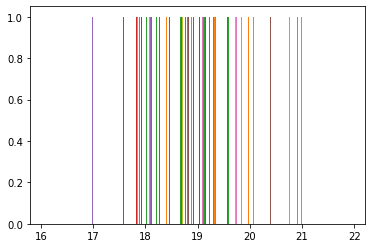

In [245]:
plt.hist(_deltaT_all_synth31,bins=7,range=(16,22))

In [197]:
print(_deltaT_low_true.values,_deltaT_mean_true.values,_deltaT_high_true.values)

25.574281813396134 20.69485293380527 17.627383474720745


In [196]:
print(_deltaT_low_synth1.values,_deltaT_mean_synth1.values,_deltaT_high_synth1.values)

23.94842785426638 20.722523437850235 18.401055520464904


The centered synthetic ensemble has a narrower range of predicted emergence times.

In [210]:
print(_deltaT_low_synth31.values,_deltaT_mean_synth31.values,_deltaT_high_synth31.values)

21.14563243081242 19.027864876988076 17.371304781340974


In [224]:
print('95%% confidence interval on emergence times from the "true" ensemble: %.2f - %.2f (%.2f)' % 
      (_deltaT_high_true.values,_deltaT_low_true.values,_deltaT_low_true.values-_deltaT_high_true.values)
     )
print('95%% confidence interval on emergence times from the "1-sigma" high-slope ensemble: %.2f - %.2f (%.2f)' % 
      (_deltaT_high_synth31.values,_deltaT_low_synth31.values,_deltaT_low_synth31.values-_deltaT_high_synth31.values)
     )

print('95%% confidence interval on emergence times from the "1-sigma" low-slope ensemble: %.2f - %.2f (%.2f)' % 
      (_deltaT_high_synth4.values,_deltaT_low_synth4.values,_deltaT_low_synth4.values-_deltaT_high_synth4.values)
     )

95% confidence interval on emergence times from the "true" ensemble: 17.63 - 25.57 (7.95)
95% confidence interval on emergence times from the "1-sigma" high-slope ensemble: 17.37 - 21.15 (3.77)
95% confidence interval on emergence times from the "1-sigma" low-slope ensemble: 19.92 - 26.61 (6.69)


The $1\sigma$ high-slope ensemble has a narrower range of predicted emergence times that is also offset. The second $1\sigma$ low-slope ensemble doesn't perform as poorly.

This is purely the effect of sampling error in the slopes (over-confidence from the synthetic ensemble and sampling bias of the forced response due to a single member).

__Takeaways__

1. For Arctic OLR, using a synthetic ensemble underestimates a 95% confidence interval on forced slopes by 30%, narrowing predicted ranges of emergence times.
2. A single ensemble is not guaranteed to have a slope near the forced response, biasing emergence times high or low. Constructing an emergence time confidence interval using a $1\sigma$ ensemble member, we find that the synthetic ensemble underestimates the 95% confidence interval on prediction times by >50% as the slope overestimation compounds the synthetic ensemble bias.